# NLP / Clustering Challenges


In [20]:
from pymongo import MongoClient
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import words
from bson.son import SON
from bson.code import Code
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, MeanShift

##### Challenge 1

Cluster sentences with K-means. If you have your own Fletcher text data, get sentences out and cluster them. If not, cluster the tweets you gathered during the last challenge set. For each cluster, print out the sentences, try to see how close the sentences are. Try different K values and try to find a K value that makes the most sense (the sentences look like they do form a meaningful cluster).

How do you deal with retweets (if you're clustering tweets)?


In [3]:
# mongo checkup
client = MongoClient('mongodb://52.10.8.92:27017/')
news = client.guardian_data.news_articles
news.count()

4996

In [66]:
k = 5

text = [i['text'] for i in news.find() if i['text'] != '']

vect = TfidfVectorizer(encoding='ascii', stop_words='english')
X = vect.fit_transform(text)
model = KMeans(k)
model.fit(X)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names() 

for i in range(k):
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :10]:
        print ' %s' % terms[ind],
    print

Cluster 0:  education  committee  universities  said  indexation  funding  government  palmer  changes  tertiary
Cluster 1:  civil  rouhani  servants  city  development  government  waterfront  guardianwitness  partnership  goals
Cluster 2:  climate  ice  change  water  sea  warming  said  ocean  global  waters
Cluster 3:  climate  change  emissions  energy  carbon  said  countries  global  australia  coal
Cluster 4:  people  labour  health  said  work  says  change  time  social  party


Cool. It seems like there's something to this. This is an example I picked out from one iteration of this code:

- Cluster 0: people and politcs
- Cluster 1: melting water
- Cluster 2: public policy, students and education
- Cluster 3: climate change and coal emissions 
- Cluster 4: offenses against women in somalia

##### Challenge 2

Draw the inertia curve over different k values. (The sklearn KMeans class has an inertia_ attribute.)


In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [140]:
k = xrange(1, 20)
inertia = [KMeans(i).fit(X).inertia_ for i in range(1, 20)]

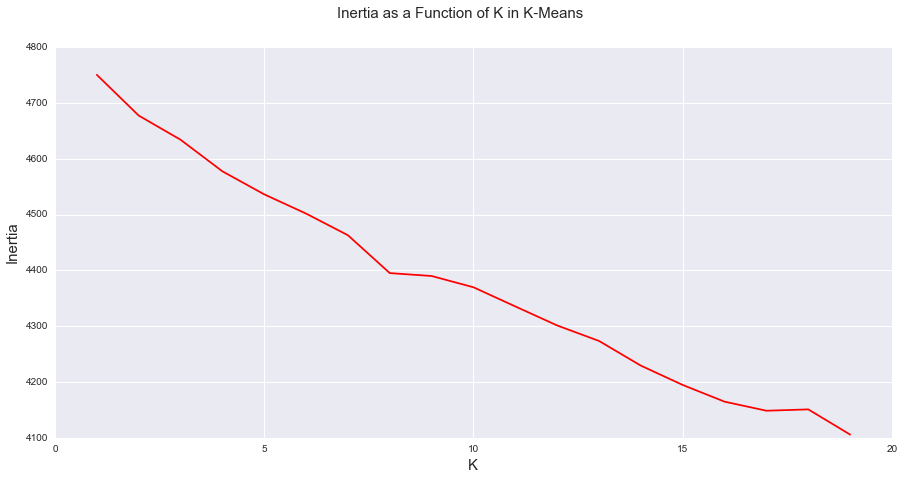

In [144]:
plt.figure(figsize=(15,7)).suptitle('Inertia as a Function of K in K-Means Clustering', fontsize='15')
plt.xlabel('K', fontsize='15')
plt.ylabel('Inertia', fontsize='15')
plt.plot(k, inertia, color='red')

##### Challenge 3

__Let's name the clusters 1__

For each cluster, find the sentence closest to the centroid of the cluster.

(You can use [sklearn.metrics.pairwise_distances](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances) or [scipy.spatial.distance](http://docs.scipy.org/doc/scipy/reference/spatial.distance.html) [check `pdist`, `cdist`, and `euclidean distance`] to find distances to the centroid). KMeans has a cluster_centroids_ attribute.

This sentence (closest to centroid) is now the name of the cluster. For each cluster, print the representative sentence, and print 'N people expressed a similar statement', or something like that relevant to your dataset. (This is very close to what amazon used to do in the reviews section.)

Find the biggest 3 clusters, and print their representative sentences. (This is close to what amazon is doing now in the reviews section, except they choose the sentence from the most helpful review instead of closest to center.)

In [72]:
from sklearn.metrics import pairwise_distances_argmin_min
closest_points = [pairwise_distances_argmin_min(KMeans(n_clusters=5).fit(X).cluster_centers_, X)]
print closest_points


[(array([ 435, 3725, 4728, 4029, 3899]), array([ 0.95608094,  0.77835829,  0.88176476,  0.51794217,  0.66751893]))]


In [73]:
for i in range(k):
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :10]:
        print ' %s' % terms[ind],
    print '\n     Closest Text to Centroid:'
    print text[closest_points[0][0][i]][:500]
    print

Cluster 0:  education  committee  universities  said  indexation  funding  government  palmer  changes  tertiary 
     Closest Text to Centroid:
HM: Hugh Muir JV: John Vidal SG: Suzanne Goldenberg JW: Jonathan Watts EGH: Emma Graham-Harrison MM: Monica Mark SB: Sarah Boseley MA: Morie Amadou MR: Mustafa Rogers RS: Dr Ramona Sunderwirth CDM: Clément Besse Desmoulieres DS: David Smith ADS: Alex Duval Smith AOdB: Anton Op de Beke CB: Coumba Bah [Jingle: The Guardian] HM Hello and welcome to the Global development podcast. I’m Hugh Muir. This month, something different. We’ll be returning to some of the people and issues we’ve talked about t

Cluster 1:  civil  rouhani  servants  city  development  government  waterfront  guardianwitness  partnership  goals 
     Closest Text to Centroid:
In 2000, world leaders came together and agreed to the eight millennium development goals – an unprecedented framework under which we have seen incredible progress against poverty and other challenges fac


##### Challenge 4

__Let's name the clusters 2__

Calculate the tf-idf of each word in each cluster (think of all sentences of a cluster together as a document). Represent each cluster with the top 1, or top 2 or... to 5 tf-idf words. For each cluster, print the name (keywords) of the cluster, and "N statements" in the cluster (N is the size of the cluster)


In [157]:
from collections import defaultdict
tp = [(label, blob) for label, blob in zip(model.labels_, text)]
paired = defaultdict(list)

for k,v in tp:
    paired[k].append(v)

for k,v in paired.items():
    print "Cluster %s had %d objects relating to the following terms" % (k, len(v))
    for ind in order_centroids[k, :5]:
        print ' %s' % terms[ind],
    print '\n'
        

Cluster 0 had 120 objects relating to the following terms
 education  committee  universities  said  indexation 

Cluster 1 had 388 objects relating to the following terms
 civil  rouhani  servants  city  development 

Cluster 2 had 1317 objects relating to the following terms
 climate  ice  change  water  sea 

Cluster 3 had 1450 objects relating to the following terms
 climate  change  emissions  energy  carbon 

Cluster 4 had 1691 objects relating to the following terms
 people  labour  health  said  work 



##### Challenge 5

__Let's name the clusters 3__

Same as the previous challenge, but this time, calculate tf-idf only for nouns (NN tag) and build keyword(s) with nouns. (This is close to what amazon switched to last year, before settling into the current design). (They would show five nouns, you would click on one and it would show sentences - linked to the reviews- that were related to that noun.)

In [ ]:
from collections import defaultdict
tp = [(label, blob) for label, blob in zip(model.labels_, text)]
paired = defaultdict(list)
for k,v in tp:
    paired[k].append(v)

for k,v in paired.items():
    print "Cluster %s had %d objects relating to the following terms" % (k, len(v))
    for ind in order_centroids[k, :5]:
        print ' %s' % terms[ind],
    print '\n'




##### Challenge 6

Cluster the same data with [MiniBatchKMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html). MiniBatchKMeans is a fast way to apply K-means to large data without much loss -- The results are very similar. Instead of using EVERY single point to find the new place of the centroid, MiniBatch just randomly samples a small number (like 100) in the cluster to calculate the new center. Since this is usually very close to the actual center, the algorithm gets there much faster. Try it and compare the results. ([Example on two-feature data](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html))

##### Challenge 7

Switch the __init__ parameter to "random" (instead of the default kmeans++) and plot the inertia curve for each of the __n_init__ values for K-Means: 1, 2, 3, 10 (n_init is the number of different runs to try with different random initializations).


##### Challenge 8

Download [this dataset on the purchase stats from clients of a wholesale distributor](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). Cluster the clients based on their annual spending features (fresh, milk, grocery, frozen, detergents_paper, delicatessen). Remember to scale the features before clustering. After finding a reasonable amount of clusters, for EACH cluster, plot the histogram for every single feature: FRESH, MILK, GROCERY, FROZEN, DETERGENTS_PAPER, DELICATESSEN, CHANNEL, REGION. Is there a natural way to characterize each cluster? How would you describe each cluster to the wholesale distributor if you were working for them?

#### Clustering Extensions (Optional)

Use the same code for your previous clustering challenges.

Repeat each challenge (except the inertia curves, since only the KMeans implementation gives a quick way of calculating that.) However, this time, try (both) Agglomerative Clustering and DBSCAN instead of KMeans.

For text clustering, use cosine distance.


Additional work:

In [102]:
from textblob import TextBlob

dates = [i['date'] for i in news.find() if i['text'] != '']
polarity = [TextBlob(i).sentiment.polarity for i in text]
subjectivity = [TextBlob(i).sentiment.subjectivity for i in text]

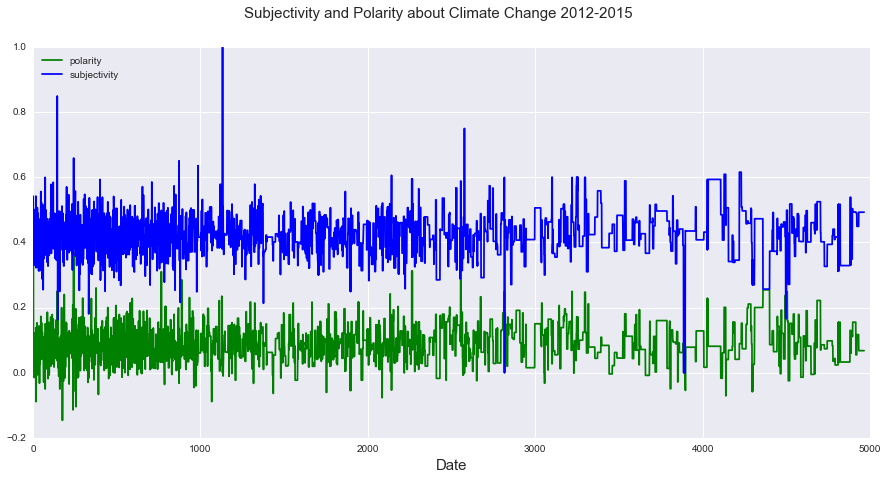

In [101]:
polarity = [TextBlob(i).sentiment.polarity for i in text]
subjectivity = [TextBlob(i).sentiment.subjectivity for i in text]
plt.figure(figsize=(15,7)).suptitle('Subjectivity and Polarity about Climate Change 2012-2015', fontsize='15')
plt.xlabel('Date', fontsize='15')
plt.plot(xrange(len(dates)), polarity, color='green')
plt.plot(xrange(len(dates)), subjectivity, color='blue')
plt.legend(['polarity', 'subjectivity'], loc='upper left')
plt.show()


In [21]:
users = client.twitter_data.users
users.count()

1347

In [22]:
#text = [i['tweets'] for i in users.find() if i['tweets'] != '']
raw_text = [i['tweets'] for i in users.aggregate(
        [{"$project":{"tweets":"$tweets"}},{"$unwind":"$tweets"}]) if i['tweets'] > ['']]

text = []
for i in raw_text:
    i  = ' '.join(filter(lambda x: bool(wordnet.synsets(x)), i.split(' ')))
    if len(i) > 5:
        text.append(i)
    

In [50]:
k = 25
vect = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
X = vect.fit_transform(text)
model = KMeans(k)
model.fit(X)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names() 

k = len(order_centroids)
for i in range(k):
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :5]:
        print ' %s' % terms[ind],
    print
    

Cluster 0:  life  god  god life  angel life  stop
Cluster 1:  follow  follow follow  guys follow  follow thank  gain follow
Cluster 2:  orang  masa  lain  orang lain  yang
Cluster 3:  new  follow  happy  day  direction
Cluster 4:  good  morning  good morning  good night  good afternoon
Cluster 5:  possible love  tried possible  follow tried  possible  tried
Cluster 6:  twitter  follow twitter  follow  new twitter  new
Cluster 7:  love  love love  love guys  guys  support love
Cluster 8:  got  time  got time  just got  just
Cluster 9:  followers  follow followers  need followers  free followers  need
Cluster 10:  thanks  follow thanks  follow  free twins  members thanks
Cluster 11:  ga  ada  ga tau  ada ga  tau
Cluster 12:  best  best friend  friend  best thing  best friends
Cluster 13:  make  just make  just  laugh  ha
Cluster 14:  like  feel like  page  feel  looks
Cluster 15:  aku  aku aku  km  yang  dong
Cluster 16:  yang  orang yang  orang  ada yang  yang yang
Cluster 17:  today  t

In [57]:
from sklearn.metrics import pairwise_distances_argmin_min

closest_points = [pairwise_distances_argmin_min(KMeans(n_clusters=k).fit(X).cluster_centers_, X, metric='cosine')]

for i in range(k):
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :5]:
        print ' %s' % terms[ind],
    print '\n Centroid Tweet: ' + text[closest_points[0][0][i]]
    print
        

Cluster 0:  life  god  god life  angel life  stop 
 Centroid Tweet: aku done

Cluster 1:  follow  follow follow  guys follow  follow thank  gain follow 
 Centroid Tweet: it Like

Cluster 2:  orang  masa  lain  orang lain  yang 
 Centroid Tweet: yang u

Cluster 3:  new  follow  happy  day  direction 
 Centroid Tweet: one direction

Cluster 4:  good  morning  good morning  good night  good afternoon 
 Centroid Tweet: i love can i have it in

Cluster 5:  possible love  tried possible  follow tried  possible  tried 
 Centroid Tweet: Followed Me on

Cluster 6:  twitter  follow twitter  follow  new twitter  new 
 Centroid Tweet: first world

Cluster 7:  love  love love  love guys  guys  support love 
 Centroid Tweet: Follow Back

Cluster 8:  got  time  got time  just got  just 
 Centroid Tweet: ka na sa

Cluster 9:  followers  follow followers  need followers  free followers  need 
 Centroid Tweet: come over

Cluster 10:  thanks  follow thanks  follow  free twins  members thanks 
 Centroid T

In [52]:
from collections import defaultdict

tp = [(label, blob) for label, blob in zip(model.labels_, text)]
paired = defaultdict(list)
for k,v in tp:
    paired[k].append(v)

for k,v in paired.items():
    print "Cluster %s had %d objects relating to the following terms" % (k, len(v))
    for ind in order_centroids[k, :5]:
        print ' %s' % terms[ind],
    print '\n'
    
    

Cluster 0 had 60 objects relating to the following terms
 life  god  god life  angel life  stop 

Cluster 1 had 125 objects relating to the following terms
 follow  follow follow  guys follow  follow thank  gain follow 

Cluster 2 had 38 objects relating to the following terms
 orang  masa  lain  orang lain  yang 

Cluster 3 had 4827 objects relating to the following terms
 new  follow  happy  day  direction 

Cluster 4 had 84 objects relating to the following terms
 good  morning  good morning  good night  good afternoon 

Cluster 5 had 20 objects relating to the following terms
 possible love  tried possible  follow tried  possible  tried 

Cluster 6 had 59 objects relating to the following terms
 twitter  follow twitter  follow  new twitter  new 

Cluster 7 had 140 objects relating to the following terms
 love  love love  love guys  guys  support love 

Cluster 8 had 93 objects relating to the following terms
 got  time  got time  just got  just 

Cluster 9 had 33 objects relating t

In [90]:
from sklearn.metrics.pairwise import pairwise_distances 
test = 'want just want sex'
clust = model.predict(vect.transform([test, test, test]))
a = int(clust.mean()) # mean cluster score for your tweets
for i in users.find():
    users.update({"_id": i["_id"]},
                 {'$set': {'cluster_score': int(np.average(model.predict(vect.transform(i['tweets']))))}})

In [94]:
a = int(clust.mean()) # mean cluster score for your tweets
a = 3
stuff = [i['user'] for i in users.find({'cluster_score': a})]
print stuff[:5]

[u'Lessa', u'Pawan Paudel', u'soe pyae tun', u'Kennedy Jo Griffiths', u'Yus ril']


In [64]:
import tweepy
import cnfg
config = cnfg.load(".twitter_config")
auth = tweepy.OAuthHandler(config["consumer_key"],
                           config["consumer_secret"])
auth.set_access_token(config["access_token"],
                      config["access_token_secret"])
api = tweepy.API(auth, wait_on_rate_limit=True)

tweets = api.user_timeline("derekjanni", count=5)
text = [i.text for i in twets]
print text


AttributeError: 'ResultSet' object has no attribute 'statuses'

In [67]:
text = [i.text for i in twets]
print text

[u"guys i think i'm gonna get a 'git r done' tattoo i'm really sorry", u'quick #mapreduce in #MongoDB to visualize some popular metal-movie tropes by decade! Video Nasty? @thisismetis http://t.co/b5nPFV8GSp', u'mfw i move to largest city in US and still no dnb scene', u'oh god the end has come, RIP #burningman \nhttp://t.co/aMpu7zkFZH', u'9th place hype #Kaggle #DataScience \n\nhttps://t.co/g3GeQNBWGG']
